# Network building

Based on artists sharing a common announcement/exhibition: using *announcements.json* / *announcements_contemporary.json* 

## Initial steps

In [2]:
import json
with open('data/artists_cleaned_v1.txt', 'r', encoding='utf-8') as f:
    artists = f.read().splitlines()

with open('data/announcements.json', 'r', encoding='utf-8') as f:
    announcements = json.load(f)

## 1) Network building

Something like:

- Add all artists (from the txt file) to a node in the graph
- Run through all announcements, add edges between artists that share an announcement

- Graph should be undirected + weighted, weight = number of announcements shared

In [3]:
#import graph_tool as gt
#from graph_tool import inference
from graph_tool.all import * #Otherwise, draw_hierarchy will not be found in any case (even if importing graph_tool.draw)

In [4]:
g = Graph(directed=False)

# Create a dictionary to map artist names to vertices
artist_to_vertex = {}

for announcement in announcements.values():
    announcement_artists = announcement['artists']
    for artist in artists:
        # If the artist is not already in the graph, add them
        if artist not in artist_to_vertex:
            v = g.add_vertex()
            artist_to_vertex[artist] = v

In [ ]:
g = Graph(directed=False)

# Create a dictionary to map artist names to vertices
artist_to_vertex = {}

for announcement in announcements.values():
    announcement_artists = announcement['artists']
    for artist in artists:
        # If the artist is not already in the graph, add them
        if artist not in artist_to_vertex:
            v = g.add_vertex()
            artist_to_vertex[artist] = v

artist_name = g.new_vertex_property("string") #vertex_to_artist = {v: artist for artist, v in artist_to_vertex.items()}
for artist,v in artist_to_vertex.items():
    artist_name[v] = artist

g.vertex_properties["artist_name"] = artist_name

import itertools

edge_weights = {}
for announcement in announcements.values():
    artists_ = announcement['artists']
    for artist1, artist2 in itertools.combinations(artists_, 2):
        # Check if the edge already exists (this returns the edge, or None)
        edge = g.edge(artist_to_vertex[artist1], artist_to_vertex[artist2])
        if edge:
            edge_weights[edge] += 1
        else:
            edge = g.add_edge(artist_to_vertex[artist1], artist_to_vertex[artist2])
            edge_weights[edge] = 1


weight = g.new_edge_property("int")
for edge, weight_value in edge_weights.items():
    weight[edge] = weight_value
g.edge_properties["weight"] = weight

Make an artist name from vertex dict(/flip out artist_to_vertex dictionary) so we can look up artists by vertex's property 

In [5]:
artist_name = g.new_vertex_property("string") #vertex_to_artist = {v: artist for artist, v in artist_to_vertex.items()}
for artist,v in artist_to_vertex.items():
    artist_name[v] = artist

g.vertex_properties["artist_name"] = artist_name

Add edges:

In [6]:
import itertools

edge_weights = {}
for announcement in announcements.values():
    artists_ = announcement['artists']
    for artist1, artist2 in itertools.combinations(artists_, 2):
        # Check if the edge already exists (this returns the edge, or None)
        edge = g.edge(artist_to_vertex[artist1], artist_to_vertex[artist2])
        if edge:
            edge_weights[edge] += 1
        else:
            edge = g.add_edge(artist_to_vertex[artist1], artist_to_vertex[artist2])
            edge_weights[edge] = 1

Add edge weight property to the edges

In [7]:
weight = g.new_edge_property("int")
for edge, weight_value in edge_weights.items():
    weight[edge] = weight_value
g.edge_properties["weight"] = weight

In [8]:
#Print amount of vertices and edges
print(g.num_vertices())
print(g.num_edges())

21350
1149352


This is a bit too much. The nested block model computation crashes, so we have to compute for a smaller subset of the data.<br>
(I ran this locally, possibly Jupyter notebook can be faster)

In [9]:
def create_subgraph_from_names(g, names, name_to_vertex):
    # Create a new graph
    g_sub = Graph(directed=False)

    # Create a dictionary to map names to new vertices
    name_to_new_vertex = {}

    # Create a vertex property map for the names
    name_property = g_sub.new_vertex_property("string")

    # Add vertices to the new graph
    for name in names:
        if name in name_to_vertex:
            v = g_sub.add_vertex()
            name_property[v] = name
            name_to_new_vertex[name] = v  # Map the name to the new vertex

    g_sub.vertex_properties["name"] = name_property

    # Create an edge property map for the weights
    edge_weights = g_sub.new_edge_property("int")

    for name1, name2 in itertools.combinations(names, 2):
        # Check if the edge already exists in the original graph
        if name1 in name_to_vertex and name2 in name_to_vertex:
            edge = g.edge(name_to_vertex[name1], name_to_vertex[name2])
            if edge:
                # If the edge exists, copy its weight to the subgraph
                edge_sub = g_sub.add_edge(name_to_new_vertex[name1], name_to_new_vertex[name2])
                edge_weights[edge_sub] = g.edge_properties["weight"][edge]

    g_sub.edge_properties["weight"] = edge_weights

    return g_sub

#########################################################################################################################

def create_subgraph_from_edges(g, edges):
    # Create a new graph
    g_sub = Graph(directed=False)

    # Create a dictionary to map names to new vertices
    name_to_new_vertex = {}

    # Create a vertex property map for the names
    name_property = g_sub.new_vertex_property("string")

    # Add vertices to the new graph
    for edge in edges:
        name1 = g.vertex_properties["artist_name"][edge.source()]
        name2 = g.vertex_properties["artist_name"][edge.target()]
        if name1 not in name_to_new_vertex:
            v1 = g_sub.add_vertex()
            name_property[v1] = name1
            name_to_new_vertex[name1] = v1  # Map the name to the new vertex
        if name2 not in name_to_new_vertex:
            v2 = g_sub.add_vertex()
            name_property[v2] = name2
            name_to_new_vertex[name2] = v2  # Map the name to the new vertex

    g_sub.vertex_properties["name"] = name_property

    # Create an edge property map for the weights
    edge_weights = g_sub.new_edge_property("int")

    for edge in edges:
        name1 = g.vertex_properties["artist_name"][edge.source()]
        name2 = g.vertex_properties["artist_name"][edge.target()]
        edge_sub = g_sub.add_edge(name_to_new_vertex[name1], name_to_new_vertex[name2])
        edge_weights[edge_sub] = g.edge_properties["weight"][edge]

    g_sub.edge_properties["weight"] = edge_weights

    return g_sub

We construct a networks: `g_double` which only has edges between artists that share 2+ announcements

In [10]:
#Construct g_doubles: a subgraph of g with only edges with weight > 1, using create_subgraph_from_names
g_doubles = create_subgraph_from_edges(g, [edge for edge in g.edges() if g.edge_properties["weight"][edge] > 1])

In [11]:
print("Nodes:", g_doubles.num_vertices()), print("Edges:", g_doubles.num_edges());

Nodes: 10192
Edges: 233958


In [ ]:
state = minimize_nested_blockmodel_dl(g_doubles)
state.draw(output="block_model_doubles.png")

The other network is even smaller. It is the network of those artists, that appear in the *PainterPalette* dataset (there is typically a lot of information about these artists). Roughly ~1000

In [12]:
import pandas as pd

url = "https://raw.githubusercontent.com/me9hanics/PainterPalette/main/PainterPalette.csv"
artists = pd.read_csv(url)

In [13]:
#Find the intersection of the artists in the graph and the artists in the dataset
artists_in_graph = set(artist_name[v] for v in g.vertices())
artists_in_dataset = set(artists['artist'])
artists_in_both = artists_in_graph.intersection(artists_in_dataset)

print("Amount of artists of whom we have extra data about:", len(artists_in_both))

Amount of artists of whom we have extra data about: 1043


In [14]:
g_selected = create_subgraph_from_names(g, artists_in_both, artist_to_vertex)
print(g_selected.num_edges())

53003


Let's fit a blockmodel on them to see if we can find some things in common in communities:

In [15]:
state = minimize_nested_blockmodel_dl(g_selected)
#state.draw(output="images/artists_selected_block_model.png") #SVG is nicer, but this would take too long to render

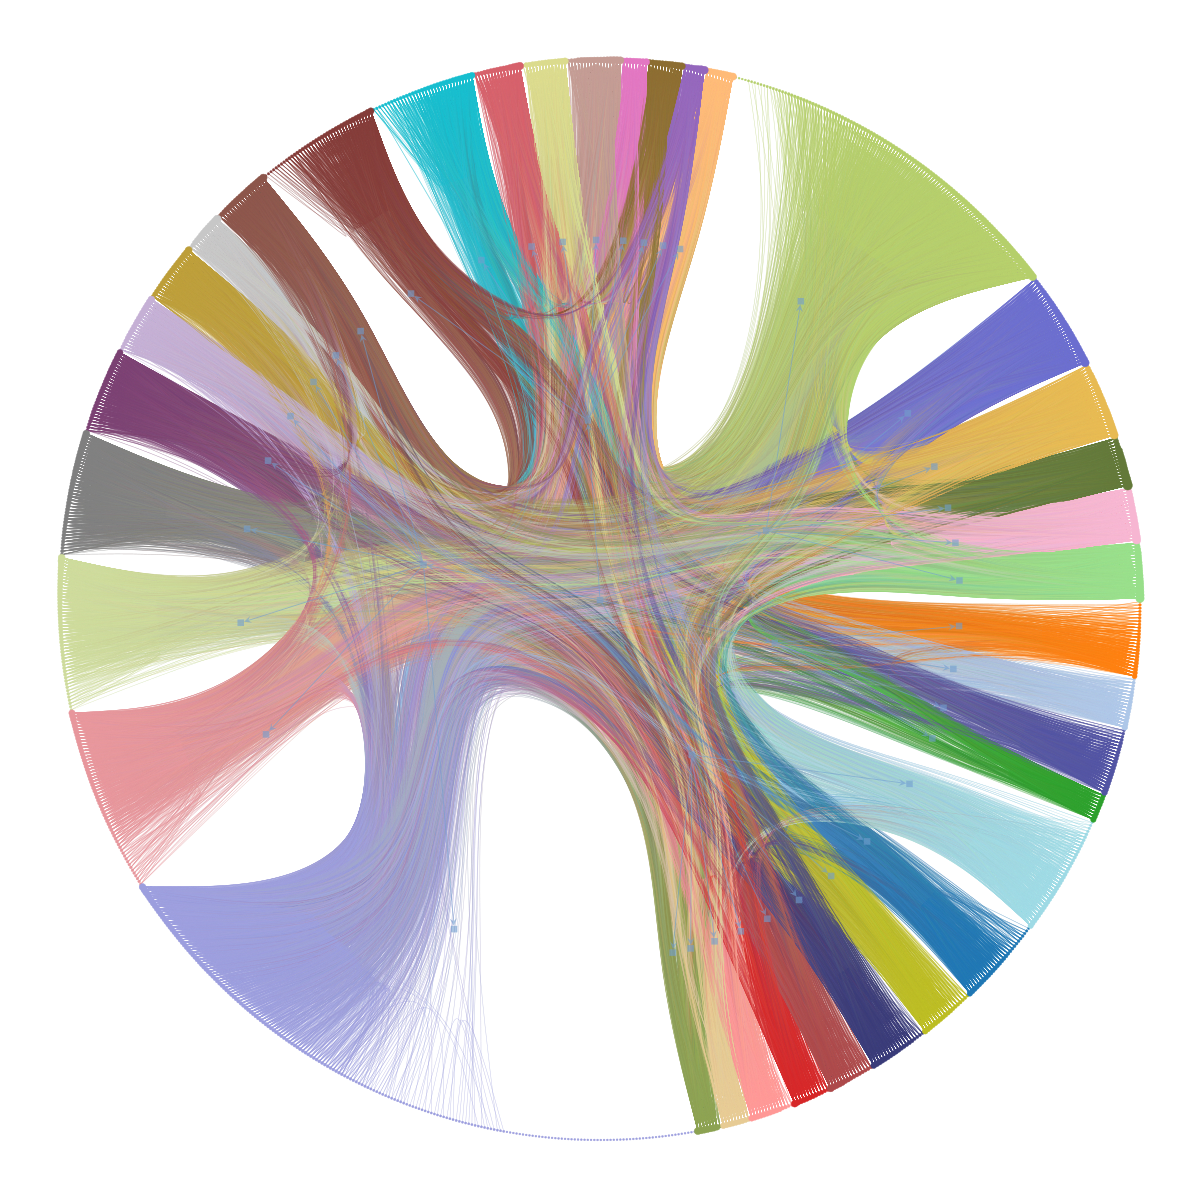

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3e3daa3c10, at 0x7f3e3dadda50>,
 <GraphView object, directed, with 1086 vertices and 1085 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f3e3d83fd90, at 0x7f3e51cdb850>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f3e3d83fd90, at 0x7f3e3dae8d50>, False), at 0x7f3e3d83fd90>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3e3d83fd90, at 0x7f3e51e9f310>)

In [21]:
state.draw()

In [32]:
state.levels[0]

<BlockState object with 1043 blocks (37 nonempty), degree-corrected, for graph <Graph object, undirected, with 1043 vertices and 53003 edges, 1 internal vertex property, 1 internal edge property, at 0x7f3e3daa3c10>, at 0x7f3e51d8d950>

The artists are split into 37 communities. Let's see if we can find some common themes in these communities

In [16]:
b = state.levels[0].get_blocks()

#Create a look up table of block ids and included artist names
block_to_artist = {}
for v in g_selected.vertices():
    block_id = b[v]
    artist = g_selected.vertex_properties["name"][v]
    if block_id not in block_to_artist:
        block_to_artist[block_id] = [] #Create the list, put the artist in it below
    block_to_artist[block_id].append(artist)

In [19]:
block_to_artist[1018]

['Adolf Hitler',
 'Paul Cadmus',
 'Judith Scott',
 'Balthus',
 'Marcelo Cidade',
 'Bhupen Khakhar',
 'Gustave Caillebotte',
 'Nicolas Poussin',
 'Gjon Mili',
 'Leonardo da Vinci',
 'Jogen Chowdhury',
 'Antonio Berni',
 'Edgar Degas',
 'Edouard Manet',
 'Frida Kahlo',
 'Jean Nouvel',
 'Alvin Langdon Coburn',
 'J.M.W. Turner',
 'Oswaldo Vigas',
 'James Hamilton',
 'Claude Monet',
 'Irma Stern',
 'Jac Leirner',
 'Louis Vivin',
 'Félix Vallotton',
 'Diego Velázquez',
 'Henri de Toulouse-Lautrec',
 'Adriana Varejão',
 'Amrita Sher-Gil']

In [39]:
artists_selected = artists[artists['artist'].isin(artists_in_both)]

In [81]:
import ast
import numpy as np

def get_column_counts(artists_df, column):
    return (artists_df[column]).value_counts()

def get_column_counts_adjusted(artists_df, column):
    return (artists_df[column]).value_counts(normalize=True)

def get_column_average(artists_df, column):
    return (artists_df[column]).mean()

def get_column_std(artists_df, column):
    return (artists_df[column]).std()

def get_locations_average(artists_df):
    all_people_locations = []
    for index, row in artists_df.iterrows():
        locations = ast.literal_eval(row['locations'])
        all_people_locations.extend(locations)

    return pd.Series(all_people_locations).value_counts(normalize=True)

def get_female_percentage(artists_df):
    values = (artists_df['gender'].value_counts(normalize=True))
    try:
        values_known = values['male'] + values['female']
    except KeyError:
        try:
            values_known = values['male']
            if values_known == 0:
                return None
            else :
                return 0
        except KeyError:
            try:
                values_known = values['female']
                if values_known == 0:
                    return None
                else:
                    return 100
            except KeyError:
                return None
    return 100*values['female'] / values_known

get_column_counts_adjusted(artists, 'Nationality')

American               0.149137
French                 0.094495
British                0.081758
Italian                0.078882
German                 0.046015
                         ...   
British,Jewish         0.000411
Azerbaijani            0.000411
Italian,Argentinean    0.000411
Slovak                 0.000411
Spanish,Colombian      0.000411
Name: Nationality, Length: 288, dtype: float64

In [88]:
get_column_counts_adjusted(artists_selected, 'Nationality')

American             0.280093
French               0.085648
Italian              0.085648
German               0.081019
British              0.067130
                       ...   
Hungarian            0.002315
South Korean         0.002315
Venezuelan           0.002315
Armenian,Lebanese    0.002315
Armenian             0.002315
Name: Nationality, Length: 101, dtype: float64

In [91]:
get_female_percentage(artists_selected)

26.770126091173616

In [92]:
artists_americans = artists_selected[(artists_selected['Nationality']=='American') | artists_selected['citizenship'].str.contains('United States')]
get_female_percentage(artists_americans)

30.08474576271186

In [79]:
blocks_nationality = []; blocks_citizenship = []; blocks_gender = []; blocks_birth_year = []; blocks_wikiart_pictures_count = []; blocks_styles = []; blocks_movement = []; blocks_size = []
for block_id, artists_in_block in block_to_artist.items():
    artists_in_block_df = artists_selected[artists_selected['artist'].isin(artists_in_block)]
    blocks_nationality.append(get_column_counts_adjusted(artists_in_block_df, 'Nationality'))
    blocks_citizenship.append(get_column_counts_adjusted(artists_in_block_df, 'citizenship'))
    blocks_gender.append(get_female_percentage(artists_in_block_df))
    blocks_birth_year.append(get_column_average(artists_in_block_df, 'birth_year'))
    blocks_wikiart_pictures_count.append(get_column_average(artists_in_block_df, 'wikiart_pictures_count'))
    blocks_styles.append(get_column_counts_adjusted(artists_in_block_df, 'styles'))
    blocks_movement.append(get_column_counts_adjusted(artists_in_block_df, 'movement'))
    #Add amount of artists in block to the dataframe
    blocks_size.append(len(artists_in_block))
#DF
block_data = pd.DataFrame({'Size':blocks_size, 'Nationality': blocks_nationality, 'citizenship': blocks_citizenship, 'gender': blocks_gender, 'birth_year': blocks_birth_year, 'wikiart_pictures_count': blocks_wikiart_pictures_count, 'styles': blocks_styles, 'movement': blocks_movement})


In [190]:
block_data.sort_values(by='birth_year', ascending=True)

,Size,Nationality,citizenship,gender,birth_year,wikiart_pictures_count,styles,movement
1,36,Chinese 0.272727 Japanese ...,People's Republic of China ...,20.000000,1850.657143,19.750000,Conceptual Art ...,Conceptual Art 0.1875 Con...
25,29,French 0.545455 Venezuelan ...,France ...,22.222222,1858.535714,211.277778,"Impressionism, Romanticism, Unknown ...",Post-Impressionism 0.166667 Romanticis...
32,26,Austrian 0.235294 French ...,France 0.28 Germany ...,20.000000,1859.769231,129.600000,"Symbolism, Unknown ...",Expressionism 0.40 Symbolism 0.25 Su...
29,25,French 0.352941 Italian ...,France ...,0.000000,1883.360000,132.941176,"Expressionism, Unknown ...",Abstract Art 0.235294 Expressionism ...
35,14,"German 0.500 American,Ger...",United States of America 0.285714 Germany...,21.428571,1887.357143,119.500000,"Abstract Art, Op Art ...",Constructivism 0.25 Abstract Art 0.25 ...
28,15,"Dutch 0.214286 American,Ger...",Kingdom of the Netherlands 0.200000 Germany...,13.333333,1888.000000,154.142857,"Abstract Art, Expressionism, Fauvism, Impressi...",Expressionism 0.214286 Abstract Art ...
16,25,American 0.214286 French ...,France ...,48.000000,1891.360000,63.333333,Surrealism ...,Surrealism 0.388889 Pop Art ...
40,14,German 0.222222 French ...,France 0.461538 United St...,7.142857,1893.500000,107.125000,Surrealism ...,Surrealism 0.375 Dada 0.250 ...
30,8,Japanese 0.2 Spanish 0.2 Brit...,Japan 0.250 France ...,12.500000,1894.750000,294.000000,"Abstract Expressionism, Action painting, Conce...",Expressionism 0.285714 Abstract Ex...
17,34,American 0.592593 Mexican ...,United States of America 0.647059 France ...,8.823529,1897.852941,163.500000,"Abstract Art, Abstract Expressionism, Color Fi...",Abstract Art 0.2...


In [52]:
block_data['gender'].sort_values(ascending=False).values[23]

25.0

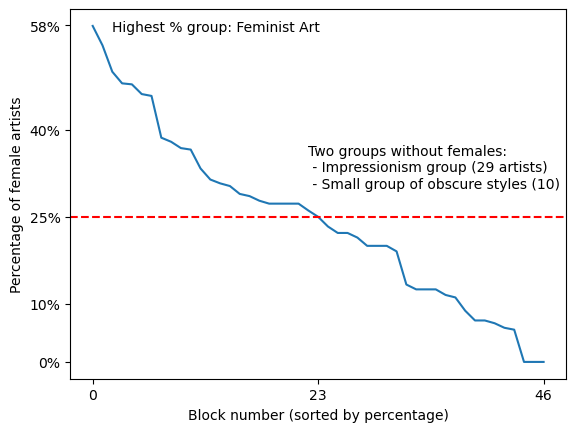

In [188]:
#Plot gender
import matplotlib.pyplot as plt

plt.plot(block_data['gender'].sort_values(ascending=False).values)
plt.ylabel('Percentage of female artists')
plt.xlabel('Block number (sorted by percentage)')
#Add ticks, with percentages
plt.xticks([0, 23, 46])
plt.yticks([0, 10, 25, 40, 58], labels=['0%', '10%', '25%', '40%', '58%'])
plt.axhline(y=25, color='r', linestyle='--')
plt.text(22, 30, 'Two groups without females:\n - Impressionism group (29 artists)\n - Small group of obscure styles (10)')
plt.text(2, 57, 'Highest % group: Feminist Art');

Text(0, 1940, 'Three earliest communities: \n - Chinese, Japanese artist group (1850), \n - Impressionism group (1858) \n - French, Austrian, German Symbolism')

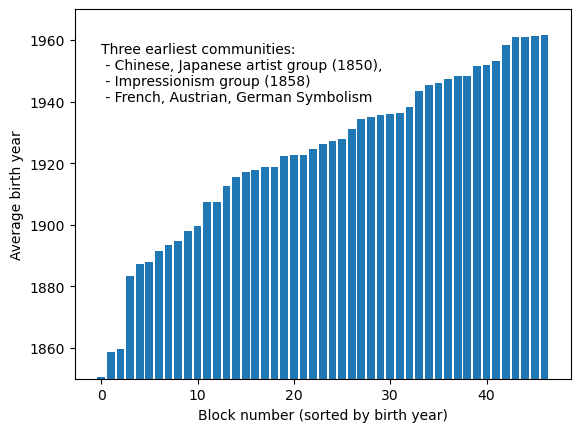

In [195]:
#Plot birth year
plt.bar(range(len(block_data['birth_year'])), block_data['birth_year'].sort_values(ascending=True).values)
plt.ylim(1850, 1970)
plt.ylabel('Average birth year')
plt.xlabel('Block number (sorted by birth year)')
plt.text(0, 1940, "Three earliest communities: \n - Chinese, Japanese artist group (1850), \n - Impressionism group (1858) \n - French, Austrian, German Symbolism")

Text(5, 250, 'Top 2:\n - 8 experts (e.g. Picasso), mostly Expressionists\n - French Impressionists ')

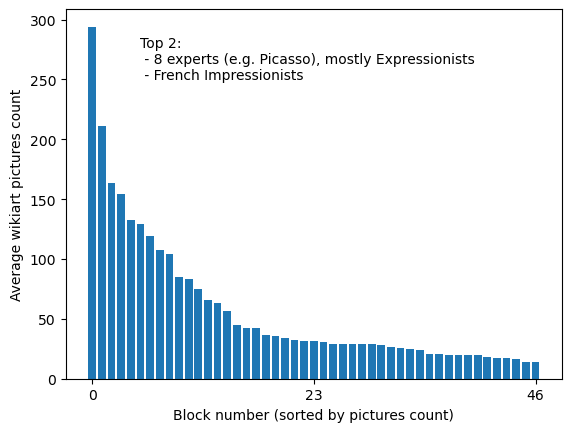

In [127]:
#Plot wikiart pictures count
plt.bar(range(len(block_data['wikiart_pictures_count'])), block_data['wikiart_pictures_count'].sort_values(ascending=False).values)
plt.ylabel('Average wikiart pictures count')
plt.xlabel('Block number (sorted by pictures count)')
plt.xticks([0, 23, 46])
plt.text(5, 250, 'Top 2:\n - 8 experts (e.g. Picasso), mostly Expressionists\n - French Impressionists ',)

In [ ]:
block_data.sort_values(by='wikiart_pictures_count', ascending=False)

In [69]:
#Late born blocks
late_birth=list(block_data['birth_year'].sort_values(ascending=False).head(4).index)
early_birth=list(block_data['birth_year'].sort_values(ascending=True).head(3).index)


In [212]:
n = 46
block_data['Size'][n],block_data['citizenship'][n], block_data['Nationality'][n]

(9,
 Italy                  0.285714
 Sweden                 0.142857
 Germany                0.142857
 Lebanon                0.142857
 Kingdom of Italy       0.142857
 Kingdom of Scotland    0.142857
 Name: citizenship, dtype: float64,
 Italian              0.75
 Armenian,Lebanese    0.25
 Name: Nationality, dtype: float64)